In [1]:
import os
import polars as pl

## For Google Colab: Manually set environment variables for AWS credentials
# os.environ["AWS_ACCESS_KEY_ID"] = "PASTE_YOUR_KEY_HERE"
# os.environ["AWS_SECRET_ACCESS_KEY"] = "PASTE_YOUR_SECRET_HERE"
# os.environ["AWS_DEFAULT_REGION"] = "us-west-2"

# from dotenv import load_dotenv
# load_dotenv()

In [2]:
country_code = ['UA', 'HU', 'CZ']  # Example country code for Ukraine

institution_country_code_lf = pl.scan_parquet("s3://openalex-bulk/institutions/country_code_00.parquet.zstd")
local_institutions_lf = institution_country_code_lf.explode("country_code").filter(
    pl.col("country_code").is_in(country_code)
)

author_institution_lf = pl.scan_parquet("s3://openalex-bulk/authors/affiliations_institution_id_00.parquet.parquet.zstd")

local_researchers_lf = author_institution_lf.explode("affiliations_institution_id").join(
    local_institutions_lf,
    left_on="affiliations_institution_id",
    right_on="institution_id",
    how="inner"
).select("author_id", "country_code")

In [3]:
# def get_researcher_count_by_country(lf, country_code):
#     df = lf.filter(
#         pl.col("country_code")==country_code
#     ).unique("author_id").collect()
#     print(df.height, df.head())
#     return df

# target_country_authors_df = get_researcher_count_by_country(local_researchers_lf, "UA")

In [4]:
author_works_lf = pl.scan_parquet(
    "s3://openalex-bulk/works/author_works/*",
    storage_options={"region": "us-west-2"}
).with_columns(
    pl.col("work_id").list.len().alias("works_count")
)

publication_year_lf = pl.scan_parquet("s3://openalex-bulk/works/publication_year/*")\
.filter(
    pl.col("publication_year")>2020,
    pl.col("publication_year")<2025,
)

oa_status_lf = pl.scan_parquet("s3://openalex-bulk/works/oa_status/*").filter(
    pl.col("oa_status")=="gold"
)

work_filter_lf = publication_year_lf.join(
    oa_status_lf,
    on="work_id",
    how="inner"
)
# work_filter_df = work_filter_lf.collect()

In [6]:
local_works_lf = author_works_lf.join(
    local_researchers_lf,
    on="author_id", how="inner"
).filter(
    pl.col("works_count") < 100,
    pl.col("works_count") > 3
).explode("work_id").join(
    work_filter_lf,
    on="work_id",
    how="inner"
)

In [7]:
local_works_df = local_works_lf.collect(engine="streaming")

/tmp/ipykernel_404021/2213412726.py:1: UserWarning: '(default_)region' not set; polars will try to get it from bucket

Set the region manually to silence this warning.
  local_works_df = local_works_lf.collect(engine="streaming")


In [8]:
local_works_df.head(), local_works_df.height

(shape: (5, 6)
 ┌─────────────┬─────────────┬─────────────┬──────────────┬──────────────────┬───────────┐
 │ author_id   ┆ work_id     ┆ works_count ┆ country_code ┆ publication_year ┆ oa_status │
 │ ---         ┆ ---         ┆ ---         ┆ ---          ┆ ---              ┆ ---       │
 │ str         ┆ str         ┆ u32         ┆ str          ┆ i64              ┆ str       │
 ╞═════════════╪═════════════╪═════════════╪══════════════╪══════════════════╪═══════════╡
 │ A5021620929 ┆ W4290466162 ┆ 86          ┆ HU           ┆ 2022             ┆ gold      │
 │ A5021620929 ┆ W4399055386 ┆ 86          ┆ HU           ┆ 2024             ┆ gold      │
 │ A5021620929 ┆ W4290466162 ┆ 86          ┆ HU           ┆ 2022             ┆ gold      │
 │ A5021620929 ┆ W4399055386 ┆ 86          ┆ HU           ┆ 2024             ┆ gold      │
 │ A5021620929 ┆ W4290466162 ┆ 86          ┆ HU           ┆ 2022             ┆ gold      │
 └─────────────┴─────────────┴─────────────┴──────────────┴────────────────

In [13]:
yearly_pub_oa = local_works_df.filter(oa_status="gold").group_by(["country_code", "publication_year"]).agg([
    pl.count("work_id").alias("open_access_pub")
])

yearly_pub_oa.sort(["country_code", "publication_year"])

country_code,publication_year,open_access_pub
str,i64,u32
"""CZ""",2021,107696
"""CZ""",2022,99013
"""CZ""",2023,101665
"""CZ""",2024,82412
"""HU""",2021,64468
…,…,…
"""HU""",2024,56522
"""UA""",2021,119939
"""UA""",2022,97311


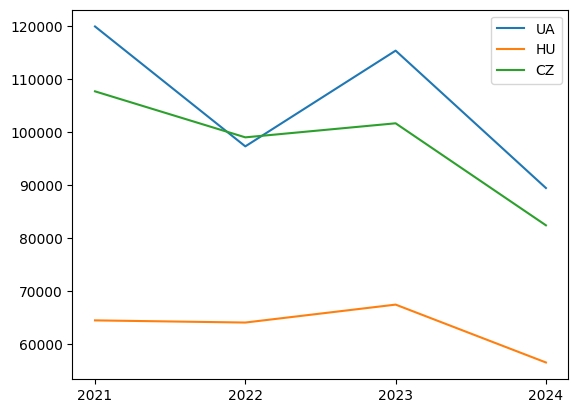

In [14]:
import matplotlib.pyplot as plt
for country in country_code:
    country_data = yearly_pub_oa.filter(pl.col("country_code") == country).sort("publication_year")
    plt.plot(country_data["publication_year"], country_data["open_access_pub"], label=country)
plt.xticks([2021, 2022, 2023, 2024])
plt.legend()
plt.show()